# 캐글 코드 참고 버전

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import psycopg2

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D

In [87]:
from scipy import stats
import plotly.express as px

In [89]:
import matplotlib

matplotlib.rcParams['font.family'] ='Malgun Gothic'

matplotlib.rcParams['axes.unicode_minus'] =False

In [86]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [3]:
# 데이터베이스 연결 설정
conn = psycopg2.connect(database="postgres", user="postgres", password="postgres123", host="postgres.c4brhfvhrm5g.ap-northeast-2.rds.amazonaws.com", port=5432)

In [4]:
# 빈 데이터 프레임 만들기
df_order = pd.DataFrame()
df_order_items = pd.DataFrame()
df_payments = pd.DataFrame()
df_products = pd.DataFrame()
df_customers = pd.DataFrame()
df_sellers = pd.DataFrame()
df_closed_deals = pd.DataFrame()
df_mql = pd.DataFrame()
df_geoloc = pd.DataFrame()
df_reviews = pd.DataFrame()

# DB에서 데이터를 가져와 데이터프레임으로 만들기
def make_df(df, db_table):
    cur = conn.cursor()
    query = 'SELECT * FROM ' + db_table
    cur.execute(query)
    temp = cur.fetchall()
    df = pd.DataFrame(temp, columns=[desc[0] for desc in cur.description])
    cur.close()
    return df

df_order = make_df(df_order, '"order"')
df_order_items = make_df(df_order_items, 'order_items')
df_payments = make_df(df_payments, 'payments')
df_products = make_df(df_products, 'products')
df_customers = make_df(df_customers, 'customers')
df_sellers = make_df(df_sellers, 'sellers')
df_closed_deals = make_df(df_closed_deals, 'closed_deals')
df_mql = make_df(df_mql, 'mql')
df_geoloc = make_df(df_geoloc, 'geoloc')
df_reviews = make_df(df_reviews, 'reviews')

## rfm분석

In [30]:
df_order['order_purchase_timestamp'] = pd.to_datetime(df_order['order_purchase_timestamp'])

# df_order와 df_customers 병합
merged_df = df_order.merge(df_customers, on='customer_id', how='left')

# df_payments를 병합
merged_df = merged_df.merge(df_payments, on='order_id', how='left')

# 조건에 맞는 order_status를 가진 데이터만 추출
order_status = ["delivered", "shipped", "invoiced", "processing"]
df_sales_filtered = merged_df[merged_df["order_status"].isin(order_status)]


In [31]:
merged_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value
0,13974,65773,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,39184,3149,sao paulo,SP,1.0,credit_card,1.0,18.12
1,13974,65773,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,39184,3149,sao paulo,SP,3.0,voucher,1.0,2.00
2,13974,65773,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,39184,3149,sao paulo,SP,2.0,voucher,1.0,18.59
3,83165,13301,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,71798,47813,barreiras,BA,1.0,boleto,1.0,141.46
4,66104,44559,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,24317,75265,vianopolis,GO,1.0,credit_card,3.0,179.12


In [32]:
df_sales_filtered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value
0,13974,65773,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,39184,3149,sao paulo,SP,1.0,credit_card,1.0,18.12
1,13974,65773,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,39184,3149,sao paulo,SP,3.0,voucher,1.0,2.00
2,13974,65773,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,39184,3149,sao paulo,SP,2.0,voucher,1.0,18.59
3,83165,13301,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,71798,47813,barreiras,BA,1.0,boleto,1.0,141.46
4,66104,44559,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,24317,75265,vianopolis,GO,1.0,credit_card,3.0,179.12


In [33]:
# R, F, M 계산
rfm_df = df_sales_filtered.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': 'max',       # R
    'order_id': 'nunique',                    # F
    'payment_value': 'sum'                   # M
}).reset_index()

# 컬럼명 변경
rfm_df.columns = ['customer_unique_id', 'R', 'F', 'M']

# M 값에 따라 내림차순 정렬
rfm_df = rfm_df.sort_values(by='M', ascending=False)

rfm_df.head()

,customer_unique_id,R,F,M
42385,42863,2017-09-29 15:24:52,1,13664.08
64845,65587,2017-04-01 15:58:41,2,7571.63
76985,77873,2018-07-15 14:49:44,1,7274.88
46758,47299,2017-02-12 20:37:36,1,6929.31
15116,15289,2018-07-25 18:10:17,1,6922.21


In [29]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94984 entries, 42385 to 41322
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_unique_id  94984 non-null  int64         
 1   R                   94984 non-null  datetime64[ns]
 2   F                   94984 non-null  int64         
 3   M                   94984 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.6 MB


In [35]:
rfm_df['R'] = pd.to_datetime(rfm_df['R'])
last_date = rfm_df['R'].max() + pd.to_timedelta(1, 'D')

rfm_df['R'] = last_date - rfm_df['R']
rfm_df['R'] = rfm_df['R'].dt.days

display(rfm_df.info(), rfm_df.head(5))

<class 'pandas.core.frame.DataFrame'>
Index: 94984 entries, 42385 to 41322
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  94984 non-null  int64  
 1   R                   94984 non-null  int64  
 2   F                   94984 non-null  int64  
 3   M                   94984 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 3.6 MB


None

,customer_unique_id,R,F,M
42385,42863,339,1,13664.08
64845,65587,520,2,7571.63
76985,77873,50,1,7274.88
46758,47299,568,1,6929.31
15116,15289,40,1,6922.21


C:\Users\lovel\AppData\Local\Temp\ipykernel_13740\350430611.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_df[col], ax = ax)
C:\Users\lovel\AppData\Local\Temp\ipykernel_13740\350430611.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_df[col], ax = ax)
C:\Users\lovel\AppData\Local

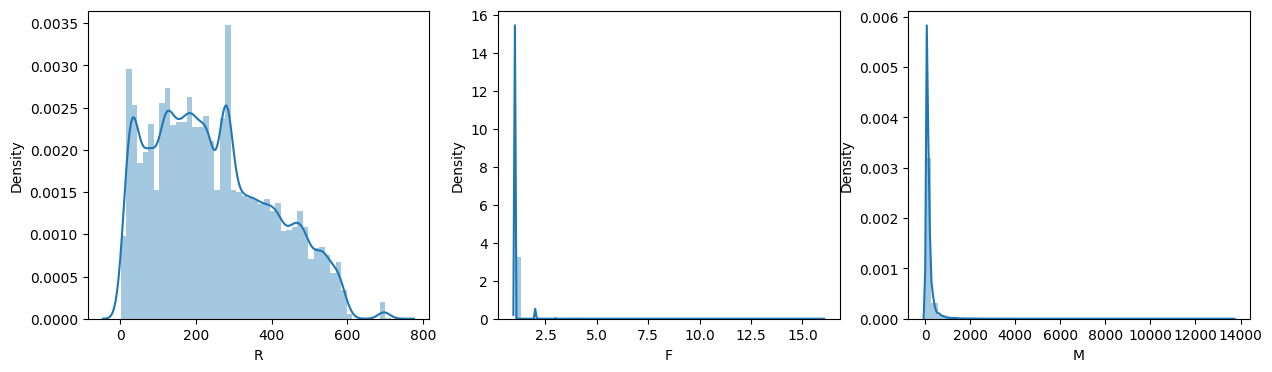

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

axes = axes.flatten()

for col, ax in zip(['R', 'F', 'M'], axes):
    sns.distplot(rfm_df[col], ax = ax)
    
plt.show()

In [40]:
print(rfm_df['R'].describe())
print('---------------------------')
print(rfm_df['F'].describe())
print('---------------------------')
print(rfm_df['M'].describe())

count    94984.000000
mean       243.441295
std        152.998564
min          1.000000
25%        119.000000
50%        224.000000
75%        352.000000
max        729.000000
Name: R, dtype: float64
---------------------------
count    94984.000000
mean         1.033858
std          0.210810
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: F, dtype: float64
---------------------------
count    94984.000000
mean       165.693252
std        226.746987
min          0.000000
25%         63.100000
50%        107.900000
75%        182.942500
max      13664.080000
Name: M, dtype: float64


In [43]:
# 점수 부여
rfm_df['R_score'] = pd.qcut(rfm_df['R'], 5, labels=range(5, 0, -1)).astype(str)
rfm_df['F_score'] = rfm_df['F'].apply(lambda x : '1' if x == 1 else '2')
rfm_df['M_score'] = pd.qcut(rfm_df['M'], 5, labels=range(1, 6)).astype(str)


In [46]:
# 점수부여 라벨링 결과

print(
        rfm_df['R_score'].value_counts(normalize=True)\
                           .sort_index(), '\n\n',
        rfm_df['F_score'].value_counts(normalize=True)\
                           .sort_index(),'\n\n',
        rfm_df['M_score'].value_counts(normalize=True)\
                           .sort_index()
       )

R_score
1    0.199802
2    0.199360
3    0.200160
4    0.199370
5    0.201308
Name: proportion, dtype: float64 

 F_score
1    0.969605
2    0.030395
Name: proportion, dtype: float64 

 M_score
1    0.200055
2    0.200002
3    0.199971
4    0.199992
5    0.199981
Name: proportion, dtype: float64


In [44]:
rfm_df.head()

,customer_unique_id,R,F,M,R_score,F_score,M_score
42385,42863,339,1,13664.08,2,1,5
64845,65587,520,2,7571.63,1,2,5
76985,77873,50,1,7274.88,5,1,5
46758,47299,568,1,6929.31,1,1,5
15116,15289,40,1,6922.21,5,1,5


## 클러스터링

In [52]:
min_max_scaler = MinMaxScaler()

rfm_cluster = rfm_df[['R', 'F', 'M']]

rfm_scaled = min_max_scaler.fit_transform(rfm_cluster)
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['R', 'F', 'M'])    
rfm_scaled.head()

,R,F,M
0,0.464286,0.000000,1.000000
1,0.712912,0.066667,0.554127
2,0.067308,0.000000,0.532409
3,0.778846,0.000000,0.507119
4,0.053571,0.000000,0.506599


c:\Users\lovel\anaconda3\envs\tp3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lovel\anaconda3\envs\tp3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lovel\anaconda3\envs\tp3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lovel\anaconda3\envs\tp3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

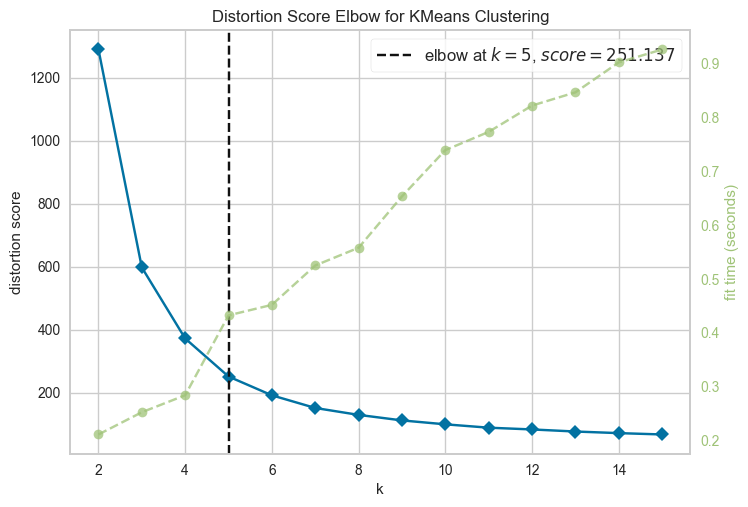

In [55]:
k = KMeans()
elbow = KElbowVisualizer(estimator = k, k = 15)
elbow.fit(rfm_scaled)
elbow.show()

plt.show()

In [57]:
# 5개 클러스터 사용 

k = KMeans(n_clusters = 5, random_state = 42)
clusters = k.fit_predict(rfm_scaled)

rfm_scaled['cluster'] = clusters
rfm_scaled

c:\Users\lovel\anaconda3\envs\tp3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,R,F,M,cluster
0,0.464286,0.000000,1.000000,3
1,0.712912,0.066667,0.554127,0
2,0.067308,0.000000,0.532409,2
3,0.778846,0.000000,0.507119,0
4,0.053571,0.000000,0.506599,2
...,...,...,...,...
94979,0.423077,0.000000,0.000851,4
94980,0.100275,0.000000,0.000797,2
94981,0.486264,0.000000,0.000737,3
94982,0.010989,0.000000,0.000702,2


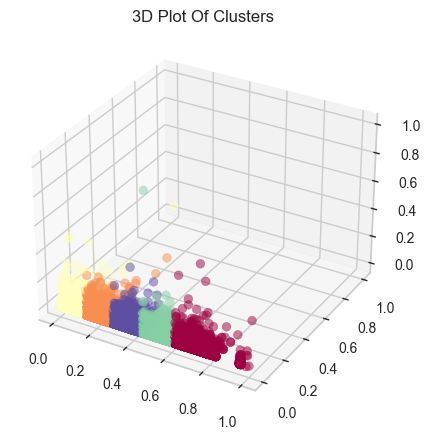

In [61]:
x = rfm_scaled['R']
y = rfm_scaled['F']
z = rfm_scaled['M']

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111, projection = '3d')
ax.scatter(x, y, z, s = 40, c = rfm_scaled['cluster'], marker = 'o', alpha = 0.5, cmap = 'Spectral')
ax.set_title("3D Plot Of Clusters")
plt.show()

In [64]:
rfm_df['cluster'] = rfm_scaled['cluster']
rfm_df['cluster'].value_counts().sort_index()

cluster
0    11868
1    24907
2    20038
3    15525
4    22646
Name: count, dtype: int64

In [65]:
def compute_weight(tmp, var):
    cv_values = [tmp[('std', var)][i] / tmp[('mean', var)][i] for i in range(4)]
    return np.min(cv_values) / np.sum(cv_values)

tmp = rfm_df.pivot_table(index='cluster', values=['R', 'F', 'M'], aggfunc=['mean', 'std'])

w_r = compute_weight(tmp, 'R')
w_f = compute_weight(tmp, 'F')
w_m = compute_weight(tmp, 'M')

print(w_r, w_f, w_m)


0.2492000561863569 0.23119067385680556 0.24094570751623287


In [66]:
# 가중치 합 1이 되도록 계산
W_R = w_r / (w_r + w_f + w_m)
W_F = w_f / (w_r + w_f + w_m)
W_M = w_m / (w_r + w_f + w_m)

print(f'Weight of Recency  : {W_R}')
print(f'Weight of Frequency: {W_F}')
print(f'Weight of Monetary : {W_M}')
print(f'Total sum of weight: {np.sum([W_R, W_F, W_M])}')

Weight of Recency  : 0.34546994053081864
Weight of Frequency: 0.32050325176838046
Weight of Monetary : 0.33402680770080084
Total sum of weight: 1.0


In [69]:
rfm_df['RFM_score'] = (rfm_df['R_score'].astype('int64') * W_R / 5 * 100 \
                        + rfm_df['F_score'].astype('int64') * W_F / 2 * 100 \
                        + rfm_df['M_score'].astype('int64') * W_M / 5 * 100)
rfm_df['RFM_score'] = rfm_df['RFM_score'].round(2)
rfm_df.head()

,customer_unique_id,R,F,M,R_score,F_score,M_score,cluster,RFM_score
42385,42863,339,1,13664.08,2,1,5,2,63.25
64845,65587,520,2,7571.63,1,2,5,3,72.36
76985,77873,50,1,7274.88,5,1,5,4,83.97
46758,47299,568,1,6929.31,1,1,5,1,56.34
15116,15289,40,1,6922.21,5,1,5,4,83.97


In [70]:
rfm_df.RFM_score.describe()

count    94984.000000
mean        57.301664
std         14.323824
min         29.620000
25%         49.660000
50%         56.790000
75%         70.160000
max        100.000000
Name: RFM_score, dtype: float64

In [72]:
rfm_df['class'] = pd.qcut(rfm_df.RFM_score, 5, labels = [5, 4, 3, 2, 1]).astype(str)
rfm_df.head(10)

,customer_unique_id,R,F,M,R_score,F_score,M_score,cluster,RFM_score,class
42385,42863,339,1,13664.08,2,1,5,2,63.25,3
64845,65587,520,2,7571.63,1,2,5,3,72.36,1
76985,77873,50,1,7274.88,5,1,5,4,83.97,1
46758,47299,568,1,6929.31,1,1,5,1,56.34,4
15116,15289,40,1,6922.21,5,1,5,4,83.97,1
25504,25796,467,1,6726.66,1,1,5,2,56.34,4
13337,13482,283,1,6081.54,2,1,5,3,63.25,3
52618,53226,503,1,4764.34,1,1,5,0,56.34,4
71200,72019,73,1,4681.78,5,1,5,1,83.97,1
27142,27450,26,4,4655.91,5,2,5,2,100.00,1


In [75]:
def anova_for_column(col_name):
    classes = ['1', '2', '3', '4', '5']
    df_by_class = [rfm_df[rfm_df['class'] == cls][col_name] for cls in classes]
    return stats.f_oneway(*df_by_class)

results_r = anova_for_column('R')
results_f = anova_for_column('F')
results_m = anova_for_column('M')

print(results_r, results_f, results_m)


F_onewayResult(statistic=28795.16378055667, pvalue=0.0) F_onewayResult(statistic=2165.102710770666, pvalue=0.0) F_onewayResult(statistic=2703.9563952208096, pvalue=0.0)


In [ ]:
# statistic: F-통계량 값/ F-통계량 값이 높을수록 그룹 간의 차이가 통계적으로 의미 있음을 나타냄
# pvalue: 귀무 가설을 기각할 수 있는 확률값 / 일반적으로 p-value < 0.05 이면 그룹 간의 차이가 통계적으로 유의하다고 판단

# R,F,M 모두 p-value = 0.0 => 그룹 간의 평균의 차이가 매우 통계적으로 유의함
# F-검정 값은 R, F, M 에 대해 각각 매우 높은데, 특히 'R'에 대한 F-검정 값이 가장 높음 => R값에 따른 그룹 간의 차이가 가장 큼
# R은 다른 두 요인에 비해 F검정 값이 더 크므로, 고객 간의 최근 구매 행동에 큰 차이가 있음을 의미

In [77]:
rfm_df.columns

Index(['customer_unique_id', 'R', 'F', 'M', 'R_score', 'F_score', 'M_score',
       'cluster', 'RFM_score', 'class'],
      dtype='object')

## rfm 등급에 따른 주별 고객 수

In [81]:
rfm_customer = pd.merge(rfm_df, df_customers, on='customer_unique_id', how='left')
rfm_state = rfm_customer.groupby(['class', 'customer_state']).size().reset_index(name='Counts')
rfm_state

,class,customer_state,Counts
0,1,AC,21
1,1,AL,85
2,1,AM,31
3,1,AP,18
4,1,BA,701
...,...,...,...
130,5,RS,1172
131,5,SC,767
132,5,SE,68
133,5,SP,8183


In [88]:
fig = px.bar(rfm_state, 
             x='customer_state', 
             y='Counts', 
             color='class',
             title='Customer Counts by State for each Class',
             labels={'customer_state': 'State', 'Counts': 'Number of Customers'})
fig.show()

## rfm 등급별 소비 카테고리 TOP5

In [83]:
rfm_order = pd.merge(rfm_df, df_order, left_on='customer_unique_id', right_on='customer_id', how='left')
rfm_order_items = pd.merge(rfm_order, df_order_items, on='order_id', how='left')
rfm_category = pd.merge(rfm_order_items, df_products, on='product_id', how='left')

rfm_category= rfm_category.groupby(['class', 'product_category_name']).size().reset_index(name='Counts')
top5_categories = rfm_category.groupby('class').apply(lambda x: x.nlargest(5, 'Counts')).reset_index(drop=True)
top5_categories


,class,product_category_name,Counts
0,1,bed_bath_table,1874
1,1,health_beauty,1679
2,1,sports_leisure,1507
3,1,furniture_decor,1498
4,1,computers_accessories,1361
5,2,bed_bath_table,2128
6,2,health_beauty,1782
7,2,sports_leisure,1598
8,2,furniture_decor,1517
9,2,computers_accessories,1428


In [90]:
fig = px.bar(top5_categories, 
             x='product_category_name', 
             y='Counts', 
             color='class',
             title='Top 5 Categories by Purchase for each Class',
             labels={'product_category_name': 'Product Category', 'Counts': 'Number of Purchases'})
fig.show()

In [ ]:
# 많이 구매한 카테고리는 rfm그룹 모두 bed_bath_table > health_beauty > sports_leisure > furniture_decor > computers_accessories  순으로 나옴....

In [ ]:
## rfm 등급별 결제수단

In [85]:
rfm_payment = pd.merge(rfm_order, df_payments, on='order_id', how='left')
rfm_payment = rfm_payment.groupby(['class', 'payment_type']).size().reset_index(name='Counts')
rfm_payment


,class,payment_type,Counts
0,1,boleto,3397
1,1,credit_card,13232
2,1,debit_card,240
3,1,not_defined,1
4,1,voucher,997
5,2,boleto,3735
6,2,credit_card,14288
7,2,debit_card,270
8,2,voucher,1018
9,3,boleto,3588


In [91]:
fig = px.bar(rfm_payment, 
             x='payment_type', 
             y='Counts', 
             color='class',
             title='Payment Type Usage for each Class',
             labels={'payment_type': 'Payment Type', 'Counts': 'Usage Count'})
fig.show()

In [ ]:
# 결제수단은 rfm그룹 모두 credit_card > boleto > voucher > debit_card > not_defined  순으로 나옴....

## rfm 그룹 별 주문상태

In [92]:
rfm_order = pd.merge(rfm_df, df_order, left_on='customer_unique_id', right_on='customer_id', how='inner')

order_status_counts = rfm_order.groupby(['class', 'order_status']).size().reset_index(name='Counts')

fig = px.bar(order_status_counts, 
             x='order_status', 
             y='Counts', 
             color='class',
             title='Order Status Distribution by Class',
             labels={'order_status': 'Order Status', 'Counts': 'Number of Orders'})
fig.show()


In [93]:
order_status_counts

,class,order_status,Counts
0,1,canceled,110
1,1,delivered,16600
2,1,invoiced,47
3,1,processing,51
4,1,shipped,180
5,1,unavailable,103
6,2,canceled,117
7,2,created,1
8,2,delivered,17959
9,2,invoiced,54


In [96]:
rfm_df_payment = pd.merge(rfm_df, df_payments, left_on='customer_unique_id', right_on='order_id', how='inner')

avg_payment = rfm_df_payment.groupby('class')['payment_value'].mean().reset_index()

fig = px.bar(avg_payment, 
             x='class', 
             y='payment_value', 
             title='Average Payment Value by Class',
             labels={'class': 'Class', 'payment_value': 'Average Payment Value'})
fig.show()
